In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score


In [2]:
selected_ticker = ['SNA','VICI','UHS','BWA','MRO']
df_dict = {}
for i in selected_ticker:
    df_dict[i] = pd.read_csv(f'./stock_dfs2/{i}_2.csv')

In [ ]:
def add_feature(f):
    n = 7
    f['loc_min'] = f.iloc[argrelextrema(f.Close.values, np.less_equal, order=n)[0]]['Close']
    f['loc_max'] = f.iloc[argrelextrema(f.Close.values, np.greater_equal, order=n)[0]]['Close']
    f['hold'] = ~f.index.isin(f['loc_min'].dropna().index) & ~f.index.isin(f['loc_max'].dropna().index)
    f['label'] = 0  
    f.loc[f['loc_min'].notna(), 'label'] = 1
    f.loc[f['loc_max'].notna(), 'label'] = 2
    return f


def gambar(f,target='label'):
    f['Date'] = pd.to_datetime(f['Date'], utc=True)
    plt.figure(figsize=(12, 6))
    plt.plot(f['Date'], f['Close'], label='Close Price', color='black')
    plt.scatter(f['Date'][f[target] == 1], f['Close'][f[target] == 1], 
               color='green', label='Label 1 (Local Minima)', marker='o')
    plt.scatter(f['Date'][f[target] == 2], f['Close'][f[target] == 2], 
               color='red', label='Label 2 (Local Maxima)', marker='o')

    plt.title('Price Chart with Labels')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

# def split_data(f):
#     f['Date'] = pd.to_datetime(f['Date'],utc=True)
#     f = f.sort_values(by='Date')
#     train_ratio = 0.85
#     split_index = int(len(f) * train_ratio)
#     train_data = f.iloc[:split_index]
#     test_data = f.iloc[split_index:]
#     print(f"Training data size: {len(train_data)}")
#     print(f"Test data size: {len(test_data)}")
#     return train_data, test_data

In [4]:
def add_technical_indicators(df, window=10):
    df = df.copy()
    
    df['SMA'] = df['Close'].rolling(window=window).mean()
    
    weights = np.arange(1, window + 1)
    df['WMA'] = df['Close'].rolling(window).apply(
        lambda x: np.dot(x, weights) / weights.sum(), raw=True
    )
    
    df['Momentum'] = df['Close'].diff(window)
    
    low_min = df['Low'].rolling(window=window).min()
    high_max = df['High'].rolling(window=window).max()
    df['Stochastic_K'] = ((df['Close'] - low_min) / (high_max - low_min)) * 100
    
    df['Stochastic_D'] = df['Stochastic_K'].rolling(window=window).mean()
    
    change = df['Close'].diff(1)
    gain = (change.where(change > 0, 0)).rolling(window=window).mean()
    loss = (-change.where(change < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    df['Williams_R'] = ((high_max - df['Close']) / (high_max - low_min)) * -100
    
    df['A/D_Oscillator'] = ((df['High'] - df['Close'].shift(1)) / 
                           (df['High'] - df['Low']))
    
    mean_deviation = lambda x: np.mean(np.abs(x - np.mean(x)))
    df['CCI'] = ((df['Close'] - df['Close'].rolling(window=window).mean()) / 
                 (0.015 * df['Close'].rolling(window=window).apply(mean_deviation, raw=True)))
    
    return df

def add_date_features(df):
    if 'Date' not in df.columns:
        raise ValueError("DataFrame harus mengandung kolom 'Date'.")
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        raise TypeError("Kolom 'Date' harus bertipe datetime.")

    # Menambahkan kolom 'day' yang berisi hari dalam bulan
    df['day'] = df['Date'].dt.day

    # Menambahkan kolom 'day_of_week' yang berisi hari dalam minggu (0=Senin, 6=Minggu)
    df['day_of_week'] = df['Date'].dt.dayofweek

    # Menambahkan kolom 'month' yang berisi bulan
    df['month'] = df['Date'].dt.month

    # Menambahkan kolom 'year' yang berisi tahun
    df['year'] = df['Date'].dt.year

    return df

features = ['SMA', 'WMA',
       'Momentum', 'Stochastic_K', 'Stochastic_D', 'RSI', 'MACD',
       'MACD_Signal', 'Williams_R', 'A/D_Oscillator', 'CCI']

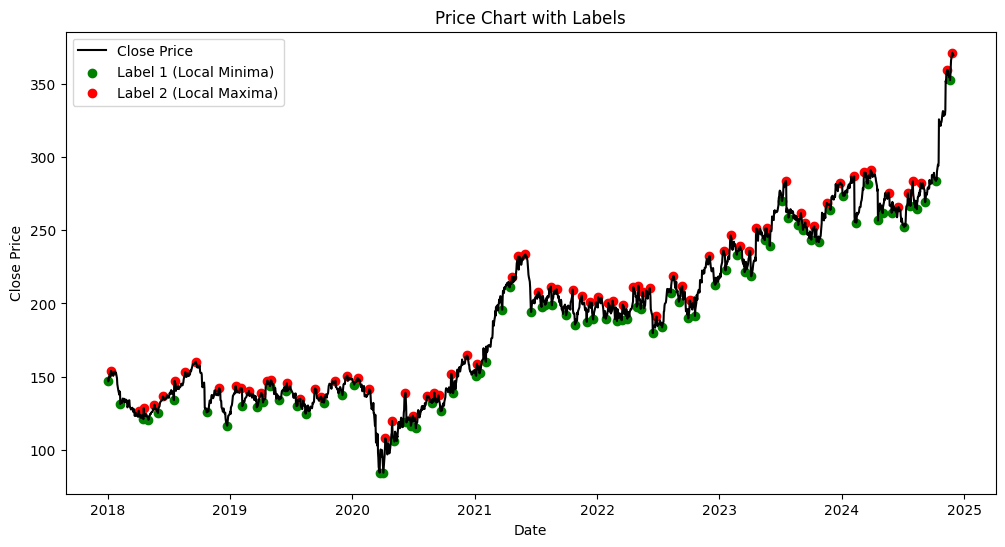

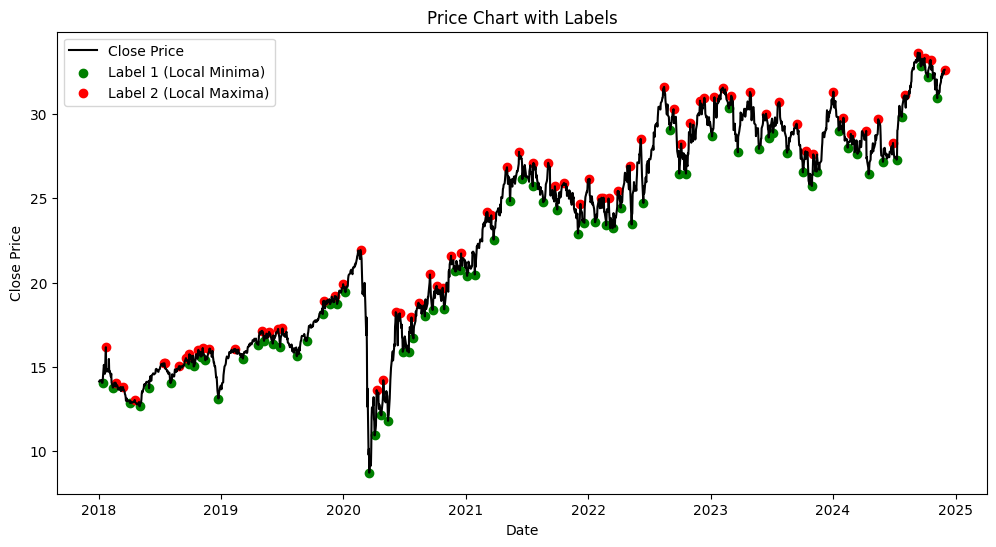

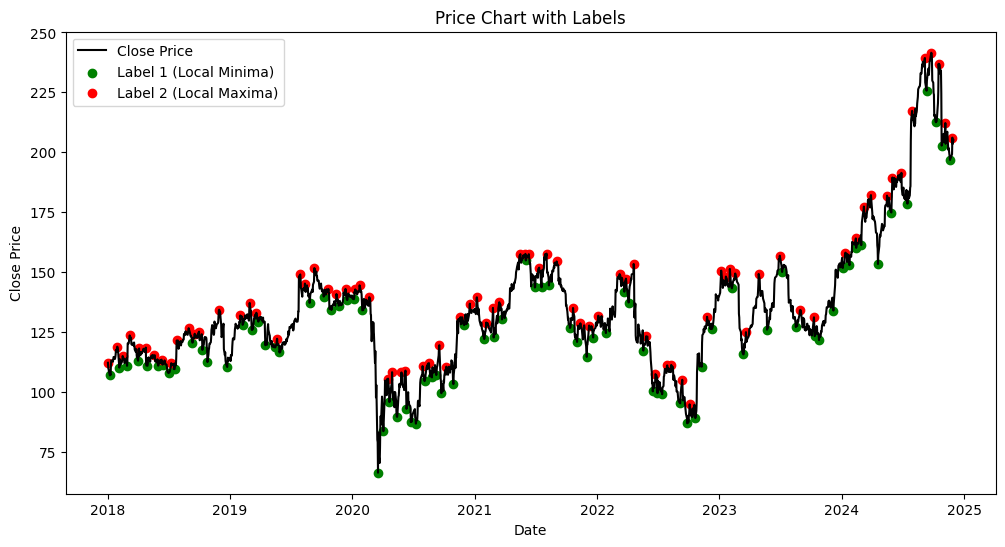

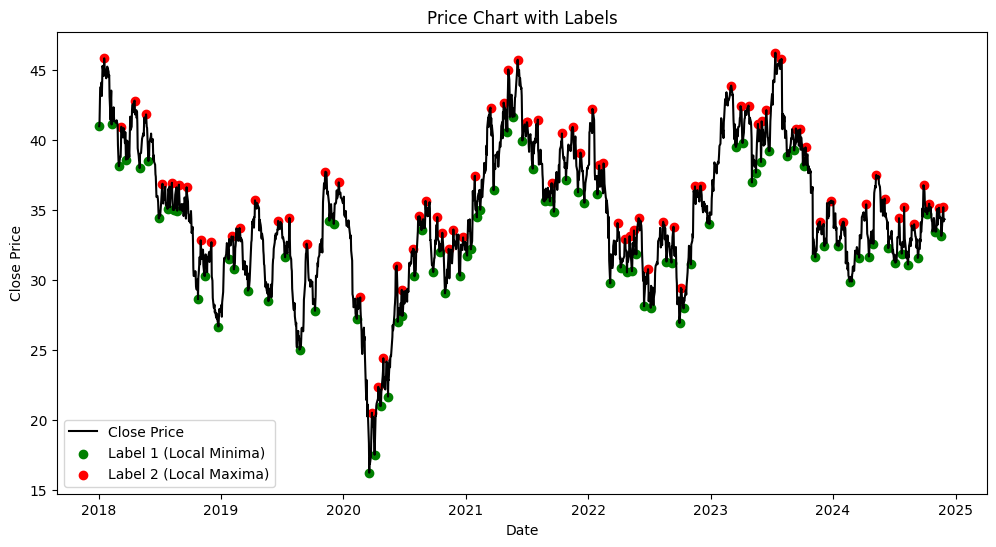

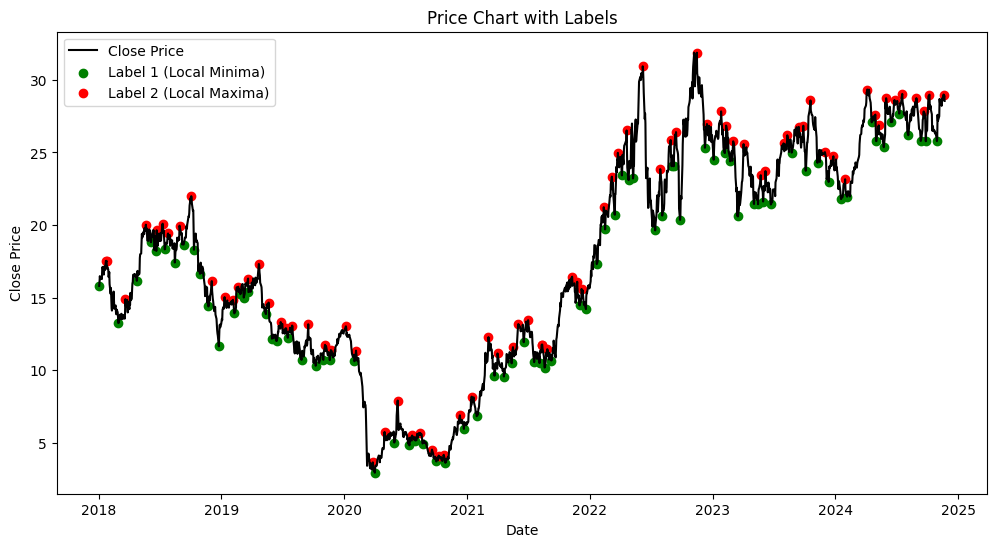

In [5]:
for i in df_dict:
    df_dict[i]['Date'] = pd.to_datetime(df_dict[i]['Date'],utc=True)
    df_dict[i] = add_feature(df_dict[i])
    df_dict[i] = add_date_features(df_dict[i])
    df_dict[i] = add_technical_indicators(df_dict[i])
    gambar(df_dict[i])


# SNA

In [6]:
df_dict['SNA'].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,loc_min,loc_max,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,2018-01-02 05:00:00+00:00,146.242915,148.345498,144.324611,148.177963,727700,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2018-01-03 05:00:00+00:00,148.002125,148.253433,145.480698,146.753983,434800,0.0,0.0,146.753983,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.113594,-0.022719,NaN,0.027218,NaN
2,2018-01-04 05:00:00+00:00,147.331952,148.127750,146.645045,147.574875,432400,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.135813,-0.045338,NaN,0.926528,NaN
3,2018-01-05 05:00:00+00:00,148.043999,149.677481,147.667043,149.484818,407800,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000686,-0.036133,NaN,1.045845,NaN
4,2018-01-08 05:00:00+00:00,149.208355,152.198894,148.739253,152.014603,1454300,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.309429,0.032980,NaN,0.784497,NaN


In [18]:
X_train = df_dict['SNA'].dropna(subset=features)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1722 entries, 18 to 1739
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Date            1722 non-null   datetime64[ns, UTC]
 1   Open            1722 non-null   float64            
 2   High            1722 non-null   float64            
 3   Low             1722 non-null   float64            
 4   Close           1722 non-null   float64            
 5   Volume          1722 non-null   int64              
 6   Dividends       1722 non-null   float64            
 7   Stock Splits    1722 non-null   float64            
 8   loc_min         78 non-null     float64            
 9   loc_max         76 non-null     float64            
 10  hold            1722 non-null   bool               
 11  label           1722 non-null   int64              
 12  day             1722 non-null   int64              
 13  day_of_week     1722 non-null   

In [8]:
y_train = X_train['label']  
X_train = X_train.drop(columns=['label','Date','Open','High','Low','Close','Volume','Dividends','Stock Splits','loc_min','loc_max','hold'])

In [13]:
y_train

18      0
19      0
20      0
21      0
22      0
       ..
1735    0
1736    0
1737    2
1738    0
1739    0
Name: label, Length: 1722, dtype: int64

In [10]:
# Logistic Regression Parameters
lr_params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# XGBoost Parameters
xgb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__gamma': [0.5, 1, 1.5, 2, 5],               
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.6, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]         
}

# Random Forest Parameters
rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]         
}

In [11]:
models = {
    'Logistic Regression': {
        'estimator': LogisticRegression(),
        'params': lr_params
    },
    'XGBoost': {
        'estimator': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': xgb_params
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(),
        'params': rf_params
    }
}

In [40]:
scoring = {
    'Recall': make_scorer(recall_score, average='macro'),
    'Precision': make_scorer(precision_score, average='macro'),
    'F1_Score': make_scorer(f1_score, average='macro')
}

tscv = TimeSeriesSplit(n_splits=5)
results = []

In [13]:

for model_name, model_info in models.items():
    estimator = model_info['estimator']
    param_grid = model_info['params']
    
    for scaler_option in [True, False]:
        steps = []
        if scaler_option:
            steps.append(('scaler', StandardScaler()))
        steps.append(('classifier', estimator))
        
        pipeline = Pipeline(steps)
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=tscv,
            scoring=scoring,
            refit='F1_Score',  # Fitur utama untuk refit
            return_train_score=False,
            verbose=1,
            n_jobs=-1  # Menggunakan semua core yang tersedia
        )
        print(f"Processing {model_name} with {'StandardScaler' if scaler_option else 'No Scaler'}...")
        grid_search.fit(X_train, y_train)
        
        # Mengambil Hasil GridSearch
        for i in range(len(grid_search.cv_results_['params'])):
            params = grid_search.cv_results_['params'][i]
            mean_recall = grid_search.cv_results_['mean_test_Recall'][i]
            mean_precision = grid_search.cv_results_['mean_test_Precision'][i]
            mean_f1 = grid_search.cv_results_['mean_test_F1_Score'][i]
            
            results.append({
                'Model': model_name,
                'Scaler': 'StandardScaler' if scaler_option else 'No Scaler',
                'Parameters': params,
                'Mean Recall': mean_recall,
                'Mean Precision': mean_precision,
                'Mean F1 Score': mean_f1
            })

print("Grid Search selesai!")


Processing Logistic Regression with StandardScaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Processing Logistic Regression with No Scaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Processing XGBoost with StandardScaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:01:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing XGBoost with No Scaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [20:08:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing Random Forest with StandardScaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Processing Random Forest with No Scaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Grid Search selesai!


In [14]:
results_df = pd.DataFrame(results)
print(results_df.head())
results_df.to_csv('Result/SNA_grid_search_results.csv', index=False)

                 Model          Scaler  \
0  Logistic Regression  StandardScaler   
1  Logistic Regression  StandardScaler   
2  Logistic Regression  StandardScaler   
3  Logistic Regression  StandardScaler   
4  Logistic Regression  StandardScaler   

                                          Parameters  Mean Recall  \
0  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
1  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
2  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
3  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
4  {'classifier__C': 0.01, 'classifier__penalty':...     0.333333   

   Mean Precision  Mean F1 Score  
0        0.301974        0.31687  
1        0.301974        0.31687  
2        0.301974        0.31687  
3        0.301974        0.31687  
4        0.301974        0.31687  


In [15]:
results_df['Mean F1 Score'].max()

0.4396071452804371

## feature selection

In [42]:
from sklearn.model_selection import cross_validate
import datetime

model = XGBClassifier(
    colsample_bytree=1.0,
    gamma=0.5,
    learning_rate=0.3,
    max_depth=3,
    n_estimators=200,
    subsample=0.6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
def forward_feature_selection(X_train, y_train, model, scoring, cv, n_features_to_select=5):
    selected_features = []
    remaining_features = list(X_train.columns)
    feature_selection_history = []
    
    for i in range(n_features_to_select):
        best_feature = None
        best_f1 = -1
        best_metrics = {}
        
        print(f"\nMemilih fitur ke-{i+1} dari {len(remaining_features)} fitur yang tersisa.")
        for feature in remaining_features:
            # print("masuuk")
            current_features = selected_features + [feature]
            cv_results = cross_validate(
                model,
                X_train[current_features],
                y_train,
                scoring=scoring,
                cv=cv,
                n_jobs=-1
            )
            avg_f1 = cv_results['test_F1_Score'].mean()
            # Memilih fitur berdasarkan F1_Score
            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_feature = feature
                best_metrics = {
                    'Recall': cv_results['test_Recall'].mean(),
                    'Precision': cv_results['test_Precision'].mean(),
                    'F1_Score': avg_f1
                }
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            feature_selection_history.append({
                'Step': i+1,
                'Selected_Feature': best_feature,
                'Recall': best_metrics['Recall'],
                'Precision': best_metrics['Precision'],
                'F1_Score': best_metrics['F1_Score']
            })
            print(f"Fitur terpilih pada langkah ke-{i+1}: '{best_feature}' | F1 Score: {best_metrics['F1_Score']:.4f}")
        else:
            print("Tidak ada fitur yang dapat dipilih lebih lanjut.")
            break
    
    return selected_features, feature_selection_history

# 7. Melakukan Forward Feature Selection dengan TimeSeriesSplit
# ========================================
n_features_to_select = 10  # Tentukan jumlah fitur yang ingin dipilih
selected_features, feature_history = forward_feature_selection(
    X_train, y_train, model, scoring, tscv, n_features_to_select
)
print("\nFitur yang dipilih secara berurutan:", selected_features)
 
current_datetime = datetime.datetime.now().strftime("%m%d%Y_%H%M%S")

history_df = pd.DataFrame(feature_history)

csv_filename = f'./Result/SNA_feature_selection_results_{current_datetime.replace("/", "").replace(",", "").replace(":", "")}.csv'

history_df.to_csv(csv_filename, index=False)
print(f"\nHasil seleksi fitur telah disimpan ke file: {csv_filename}")



Memilih fitur ke-1 dari 15 fitur yang tersisa.
Fitur terpilih pada langkah ke-1: 'CCI' | F1 Score: 0.3445

Memilih fitur ke-2 dari 14 fitur yang tersisa.
Fitur terpilih pada langkah ke-2: 'month' | F1 Score: 0.4359

Memilih fitur ke-3 dari 13 fitur yang tersisa.
Fitur terpilih pada langkah ke-3: 'day_of_week' | F1 Score: 0.4640

Memilih fitur ke-4 dari 12 fitur yang tersisa.
Fitur terpilih pada langkah ke-4: 'year' | F1 Score: 0.4469

Memilih fitur ke-5 dari 11 fitur yang tersisa.
Fitur terpilih pada langkah ke-5: 'MACD' | F1 Score: 0.4507

Memilih fitur ke-6 dari 10 fitur yang tersisa.
Fitur terpilih pada langkah ke-6: 'MACD_Signal' | F1 Score: 0.4459

Memilih fitur ke-7 dari 9 fitur yang tersisa.
Fitur terpilih pada langkah ke-7: 'Stochastic_K' | F1 Score: 0.4445

Memilih fitur ke-8 dari 8 fitur yang tersisa.
Fitur terpilih pada langkah ke-8: 'Williams_R' | F1 Score: 0.4445

Memilih fitur ke-9 dari 7 fitur yang tersisa.
Fitur terpilih pada langkah ke-9: 'day' | F1 Score: 0.4415

Mem

Dari model terbaik yang diperoleh dari grid search, dan dilakukan pemilihan feature diperoleh model:
```
model = XGBClassifier(
    colsample_bytree=1.0,
    gamma=0.5,
    learning_rate=0.3,
    max_depth=3,
    n_estimators=200,
    subsample=0.6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
```
dan feature `CCI` , `month`, dan `day_of_week`, dengan nilai F1 macro berupa 0.464

## Percobaan

In [22]:
X_percobaan = X_train[['CCI','month','day_of_week']]
X_percobaan

,CCI,month,day_of_week
18,-178.014497,1,0
19,-227.220530,1,1
20,-164.987183,1,2
21,-129.115829,2,3
22,-115.753493,2,4
...,...,...,...
1735,179.009024,11,4
1736,182.656989,11,0
1737,130.495873,11,1
1738,82.293715,11,2


In [23]:
y_train

18      0
19      0
20      0
21      0
22      0
       ..
1735    0
1736    0
1737    2
1738    0
1739    0
Name: label, Length: 1722, dtype: int64

In [24]:
model = XGBClassifier(
    colsample_bytree=1.0,
    gamma=0.5,
    learning_rate=0.3,
    max_depth=3,
    n_estimators=200,
    subsample=0.6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_percobaan, y_train)
y_percobaan = model.predict(X_percobaan)
y_percobaan


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:04:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [25]:
X_train['label_2'] = y_percobaan

C:\Users\mhafi\AppData\Local\Temp\ipykernel_5192\1405894086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['label_2'] = y_percobaan


In [26]:
X_train

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,loc_min,loc_max,...,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI,label_2
18,2018-01-29 05:00:00+00:00,150.783167,152.014564,148.881620,149.032410,772500,0.0,0.0,NaN,NaN,...,-4.758087,2.482846,52.601406,32.469000,0.791776,1.003581,-97.517154,-0.208579,-178.014497,0
19,2018-01-30 05:00:00+00:00,147.533019,147.533019,143.512143,144.827301,1206600,0.0,0.0,NaN,NaN,...,-6.517166,12.381709,47.481436,28.743160,0.195320,0.841929,-87.618291,-0.372902,-227.220530,0
20,2018-01-31 05:00:00+00:00,145.673323,146.108922,143.218913,143.503723,765100,0.0,0.0,NaN,NaN,...,-8.259537,2.609339,41.386493,24.561557,-0.379799,0.597583,-97.390661,0.443466,-164.987183,0
21,2018-02-01 05:00:00+00:00,142.481723,143.805266,141.694298,142.305817,698800,0.0,0.0,NaN,NaN,...,-8.276321,4.915893,37.363224,24.536189,-0.921623,0.293742,-95.084107,0.142846,-129.115829,0
22,2018-02-02 05:00:00+00:00,141.258746,142.071301,139.482846,140.638855,792800,0.0,0.0,NaN,NaN,...,-12.481491,7.890263,31.068479,9.422712,-1.468603,-0.058727,-92.109737,-0.090601,-115.753493,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,2024-11-22 05:00:00+00:00,362.140015,367.119995,361.070007,365.970001,593000,0.0,0.0,NaN,NaN,...,8.848633,93.323743,79.016013,67.453320,13.134609,13.699128,-6.676257,0.945457,179.009024,0
1736,2024-11-25 05:00:00+00:00,367.500000,372.940002,367.500000,370.640015,584300,0.0,0.0,NaN,NaN,...,10.954041,90.019639,78.373148,69.949202,13.459408,13.651184,-9.980361,1.281250,182.656989,0
1737,2024-11-26 05:00:00+00:00,369.010010,372.029999,367.660004,371.350006,442500,0.0,0.0,NaN,371.350006,...,13.155060,93.100513,78.503038,74.659143,13.617135,13.644374,-6.899487,0.318075,130.495873,0
1738,2024-11-27 05:00:00+00:00,371.920013,373.899994,369.010010,369.230011,273000,0.0,0.0,NaN,NaN,...,10.130524,80.545895,77.576053,68.162057,13.416413,13.598782,-19.454105,0.521472,82.293715,0


C:\Users\mhafi\AppData\Local\Temp\ipykernel_5192\3848243647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['Date'] = pd.to_datetime(f['Date'], utc=True)


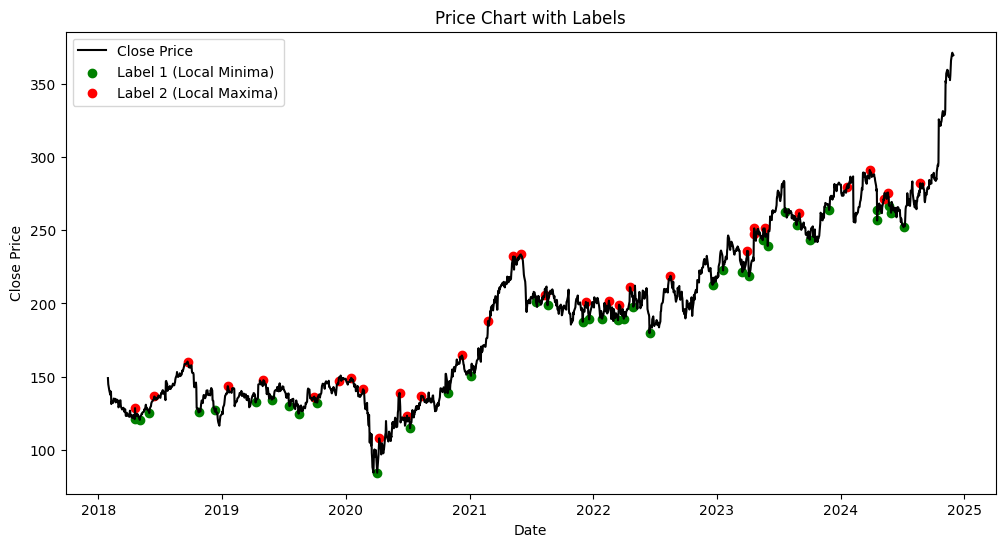

In [27]:
f = X_train

f['Date'] = pd.to_datetime(f['Date'], utc=True)
plt.figure(figsize=(12, 6))
plt.plot(f['Date'], f['Close'], label='Close Price', color='black')
plt.scatter(f['Date'][f['label_2'] == 1], f['Close'][f['label_2'] == 1], 
            color='green', label='Label 1 (Local Minima)', marker='o')
plt.scatter(f['Date'][f['label_2'] == 2], f['Close'][f['label_2'] == 2], 
            color='red', label='Label 2 (Local Maxima)', marker='o')

plt.title('Price Chart with Labels')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# VICI

In [60]:
df_dict['VICI'].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,loc_min,loc_max,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,2018-01-02 05:00:00+00:00,14.061208,14.483045,14.026056,14.131515,427900,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2018-01-03 05:00:00+00:00,14.412739,14.483045,14.061209,14.173698,231300,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.003365,0.000673,NaN,0.833334,NaN
2,2018-01-04 05:00:00+00:00,14.166670,14.412742,14.131518,14.201824,447800,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.008207,0.002180,NaN,0.850011,NaN
3,2018-01-05 05:00:00+00:00,14.201824,14.201824,14.166670,14.201824,78300,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.011907,0.004125,NaN,0.000000,NaN
4,2018-01-08 05:00:00+00:00,14.201824,14.201824,14.096364,14.201824,59200,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.014670,0.006234,NaN,0.000000,NaN


In [61]:
X_train_vici = df_dict['VICI'].dropna(subset=features)
X_train_vici.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1722 entries, 18 to 1739
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Date            1722 non-null   datetime64[ns, UTC]
 1   Open            1722 non-null   float64            
 2   High            1722 non-null   float64            
 3   Low             1722 non-null   float64            
 4   Close           1722 non-null   float64            
 5   Volume          1722 non-null   int64              
 6   Dividends       1722 non-null   float64            
 7   Stock Splits    1722 non-null   float64            
 8   loc_min         72 non-null     float64            
 9   loc_max         73 non-null     float64            
 10  hold            1722 non-null   bool               
 11  label           1722 non-null   int64              
 12  day             1722 non-null   int64              
 13  day_of_week     1722 non-null   

In [62]:
y_train = X_train_vici['label']  
X_train = X_train_vici.drop(columns=['label','Date','Open','High','Low','Close','Volume','Dividends','Stock Splits','loc_min','loc_max','hold'])

In [63]:
X_train

,day,day_of_week,month,year,SMA,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
18,29,0,1,2018,14.950582,14.909358,0.780401,45.845433,50.573072,58.246682,0.199932,0.183358,-54.154567,0.000000,-27.847270
19,30,1,1,2018,14.918944,14.881874,-0.316379,44.412600,49.283671,45.730547,0.188093,0.184305,-55.587400,-0.000048,-30.965546
20,31,2,1,2018,14.969565,14.981582,0.506207,71.633361,51.346723,56.000024,0.229954,0.193435,-28.366639,0.927539,98.088480
21,1,3,2,2018,14.961831,14.930194,-0.077334,39.828117,51.031549,49.194756,0.197877,0.194323,-60.171883,-1.015158,-53.679258
22,2,4,2,2018,14.980112,14.895553,0.182801,43.266605,51.776559,51.940349,0.177221,0.190903,-56.733395,0.300005,-41.666310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,22,4,11,2024,31.759000,31.975091,0.840000,77.018681,61.809667,74.418592,-0.070297,-0.206302,-22.981319,0.500000,77.149873
1736,25,0,11,2024,31.884000,32.115272,1.249998,89.795753,68.050109,82.722433,-0.015963,-0.168234,-10.204247,1.021510,104.734024
1737,26,1,11,2024,32.002000,32.205454,1.180000,81.049541,73.763754,79.797994,0.014823,-0.131623,-18.950459,0.000000,68.553011
1738,27,2,11,2024,32.131000,32.314181,1.289999,85.411061,78.617709,80.861246,0.056324,-0.094034,-14.588939,1.137925,101.251882


In [30]:
# Logistic Regression Parameters
lr_params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# XGBoost Parameters
xgb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__gamma': [0.5, 1, 1.5, 2, 5],               
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.6, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]         
}

# Random Forest Parameters
rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]         
}

In [31]:
models = {
    'Logistic Regression': {
        'estimator': LogisticRegression(),
        'params': lr_params
    },
    'XGBoost': {
        'estimator': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': xgb_params
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(),
        'params': rf_params
    }
}

In [32]:
scoring = {
    'Recall': make_scorer(recall_score, average='macro'),
    'Precision': make_scorer(precision_score, average='macro'),
    'F1_Score': make_scorer(f1_score, average='macro')
}

tscv = TimeSeriesSplit(n_splits=5)
results = []

In [33]:

for model_name, model_info in models.items():
    estimator = model_info['estimator']
    param_grid = model_info['params']
    
    for scaler_option in [True, False]:
        steps = []
        if scaler_option:
            steps.append(('scaler', StandardScaler()))
        steps.append(('classifier', estimator))
        
        pipeline = Pipeline(steps)
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=tscv,
            scoring=scoring,
            refit='F1_Score',  # Fitur utama untuk refit
            return_train_score=False,
            verbose=1,
            n_jobs=-1  # Menggunakan semua core yang tersedia
        )
        print(f"Processing {model_name} with {'StandardScaler' if scaler_option else 'No Scaler'}...")
        grid_search.fit(X_train, y_train)
        
        # Mengambil Hasil GridSearch
        for i in range(len(grid_search.cv_results_['params'])):
            params = grid_search.cv_results_['params'][i]
            mean_recall = grid_search.cv_results_['mean_test_Recall'][i]
            mean_precision = grid_search.cv_results_['mean_test_Precision'][i]
            mean_f1 = grid_search.cv_results_['mean_test_F1_Score'][i]
            
            results.append({
                'Model': model_name,
                'Scaler': 'StandardScaler' if scaler_option else 'No Scaler',
                'Parameters': params,
                'Mean Recall': mean_recall,
                'Mean Precision': mean_precision,
                'Mean F1 Score': mean_f1
            })

print("Grid Search selesai!")


Processing Logistic Regression with StandardScaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Processing Logistic Regression with No Scaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Processing XGBoost with StandardScaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:55:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing XGBoost with No Scaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:01:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing Random Forest with StandardScaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Processing Random Forest with No Scaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Grid Search selesai!


In [34]:
results_df = pd.DataFrame(results)
print(results_df.head())
results_df.to_csv('Result/VICI_grid_search_results.csv', index=False)

                 Model          Scaler  \
0  Logistic Regression  StandardScaler   
1  Logistic Regression  StandardScaler   
2  Logistic Regression  StandardScaler   
3  Logistic Regression  StandardScaler   
4  Logistic Regression  StandardScaler   

                                          Parameters  Mean Recall  \
0  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
1  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
2  {'classifier__C': 0.001, 'classifier__penalty'...     0.337451   
3  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
4  {'classifier__C': 0.01, 'classifier__penalty':...     0.333333   

   Mean Precision  Mean F1 Score  
0        0.304994       0.318532  
1        0.304994       0.318532  
2        0.318469       0.325548  
3        0.304994       0.318532  
4        0.304994       0.318532  


In [35]:
results_df['Mean F1 Score'].max()

0.41277689752382596

## feature selection

In [65]:
from sklearn.model_selection import cross_validate
import datetime

model_xgb = XGBClassifier(
    colsample_bytree=1.0,
    gamma=0.5,
    learning_rate=0.3,
    max_depth=4,
    n_estimators=300,
    subsample=0.6,
    random_state=42  
)

def forward_feature_selection(X_train, y_train, model, scoring, cv, n_features_to_select=5):
    selected_features = []
    remaining_features = list(X_train.columns)
    feature_selection_history = []
    
    for i in range(n_features_to_select):
        best_feature = None
        best_f1 = -1
        best_metrics = {}
        
        print(f"\nMemilih fitur ke-{i+1} dari {len(remaining_features)} fitur yang tersisa.")
        for feature in remaining_features:
            # print("masuuk")
            current_features = selected_features + [feature]
            cv_results = cross_validate(
                model,
                X_train[current_features],
                y_train,
                scoring=scoring,
                cv=cv,
                n_jobs=-1
            )
            avg_f1 = cv_results['test_F1_Score'].mean()
            # Memilih fitur berdasarkan F1_Score
            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_feature = feature
                best_metrics = {
                    'Recall': cv_results['test_Recall'].mean(),
                    'Precision': cv_results['test_Precision'].mean(),
                    'F1_Score': avg_f1
                }
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            feature_selection_history.append({
                'Step': i+1,
                'Selected_Feature': best_feature,
                'Recall': best_metrics['Recall'],
                'Precision': best_metrics['Precision'],
                'F1_Score': best_metrics['F1_Score']
            })
            print(f"Fitur terpilih pada langkah ke-{i+1}: '{best_feature}' | F1 Score: {best_metrics['F1_Score']:.4f}")
        else:
            print("Tidak ada fitur yang dapat dipilih lebih lanjut.")
            break
    
    return selected_features, feature_selection_history

# 7. Melakukan Forward Feature Selection dengan TimeSeriesSplit
# ========================================
n_features_to_select = 15 
selected_features, feature_history = forward_feature_selection(
    X_train, y_train, model_xgb, scoring, tscv, n_features_to_select
)
print("\nFitur yang dipilih secara berurutan:", selected_features)
 
current_datetime = datetime.datetime.now().strftime("%m%d%Y_%H%M%S")

history_df = pd.DataFrame(feature_history)

csv_filename = f'./Result/VICI_feature_selection_results_{current_datetime.replace("/", "").replace(",", "").replace(":", "")}.csv'

history_df.to_csv(csv_filename, index=False)
print(f"\nHasil seleksi fitur telah disimpan ke file: {csv_filename}")



Memilih fitur ke-1 dari 15 fitur yang tersisa.
Fitur terpilih pada langkah ke-1: 'Williams_R' | F1 Score: 0.3968

Memilih fitur ke-2 dari 14 fitur yang tersisa.
Fitur terpilih pada langkah ke-2: 'month' | F1 Score: 0.3990

Memilih fitur ke-3 dari 13 fitur yang tersisa.
Fitur terpilih pada langkah ke-3: 'WMA' | F1 Score: 0.4354

Memilih fitur ke-4 dari 12 fitur yang tersisa.
Fitur terpilih pada langkah ke-4: 'A/D_Oscillator' | F1 Score: 0.4325

Memilih fitur ke-5 dari 11 fitur yang tersisa.
Fitur terpilih pada langkah ke-5: 'CCI' | F1 Score: 0.4245

Memilih fitur ke-6 dari 10 fitur yang tersisa.
Fitur terpilih pada langkah ke-6: 'RSI' | F1 Score: 0.4220

Memilih fitur ke-7 dari 9 fitur yang tersisa.
Fitur terpilih pada langkah ke-7: 'Stochastic_K' | F1 Score: 0.4135

Memilih fitur ke-8 dari 8 fitur yang tersisa.
Fitur terpilih pada langkah ke-8: 'MACD' | F1 Score: 0.4136

Memilih fitur ke-9 dari 7 fitur yang tersisa.
Fitur terpilih pada langkah ke-9: 'SMA' | F1 Score: 0.4228

Memilih f

Dari model terbaik yang diperoleh dari grid search, dan dilakukan pemilihan feature diperoleh model:
```
xgb_model = XGBClassifier(
    colsample_bytree=1.0,
    gamma=0.5,
    learning_rate=0.3,
    max_depth=4,
    n_estimators=300,
    subsample=0.6,
    random_state=42  
)
```
dan feature `Williams_R` , `month`, `WMA`, dengan nilai avg F1 macro berupa 0.4354

# UHS

In [76]:
df_dict['UHS'].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,loc_min,loc_max,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,2018-01-02 05:00:00+00:00,110.745877,112.259221,109.960097,112.142807,754000,0.0,0.0,NaN,112.142807,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2018-01-03 05:00:00+00:00,111.725667,111.725667,108.951199,109.998901,845900,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.171024,-0.034205,NaN,-0.150350,NaN
2,2018-01-04 05:00:00+00:00,110.736183,110.736183,108.805699,109.416855,689000,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.349499,-0.097264,NaN,0.381915,NaN
3,2018-01-05 05:00:00+00:00,110.037719,110.037719,107.418470,108.621384,1201800,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.548803,-0.187572,NaN,0.237039,NaN
4,2018-01-08 05:00:00+00:00,108.446780,108.456483,105.982741,106.855827,1543500,0.0,0.0,106.855827,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.839541,-0.317966,NaN,-0.066660,NaN


In [77]:
X_train_uhs = df_dict['UHS'].dropna(subset=features)
X_train_uhs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1722 entries, 18 to 1739
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Date            1722 non-null   datetime64[ns, UTC]
 1   Open            1722 non-null   float64            
 2   High            1722 non-null   float64            
 3   Low             1722 non-null   float64            
 4   Close           1722 non-null   float64            
 5   Volume          1722 non-null   int64              
 6   Dividends       1722 non-null   float64            
 7   Stock Splits    1722 non-null   float64            
 8   loc_min         80 non-null     float64            
 9   loc_max         82 non-null     float64            
 10  hold            1722 non-null   bool               
 11  label           1722 non-null   int64              
 12  day             1722 non-null   int64              
 13  day_of_week     1722 non-null   

In [78]:
y_train = X_train_uhs['label']  
X_train = X_train_uhs.drop(columns=['label','Date','Open','High','Low','Close','Volume','Dividends','Stock Splits','loc_min','loc_max','hold'])

In [79]:
X_train

,day,day_of_week,month,year,SMA,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
18,29,0,1,2018,114.622378,115.319963,3.511726,75.602355,85.763259,71.496557,1.275739,0.632772,-24.397645,0.372884,114.356620
19,30,1,1,2018,115.215105,116.091451,5.927269,67.811567,83.236541,79.234667,1.543063,0.814830,-32.188433,0.684796,155.009124
20,31,2,1,2018,115.743806,116.573501,5.287018,57.703739,80.140565,74.527696,1.655213,0.982907,-42.296261,0.065442,88.062908
21,1,3,2,2018,116.128932,116.922379,3.851257,54.754509,75.718410,69.751305,1.707965,1.127918,-45.245491,0.321314,63.685367
22,2,4,2,2018,116.246313,116.850238,1.173813,34.834577,71.023976,55.368263,1.575831,1.217501,-65.165423,0.000001,-23.033931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,22,4,11,2024,200.705000,198.963637,-9.559998,39.308756,41.883511,18.839697,-5.830037,-5.585553,-60.691244,0.365617,-58.611513
1736,25,0,11,2024,199.770001,198.691820,-9.349991,48.731988,38.720801,19.935786,-5.573442,-5.583131,-51.268012,0.472505,-16.077939
1737,26,1,11,2024,199.855000,199.840910,0.849991,94.826584,41.973857,52.223939,-4.760061,-5.418517,-5.173416,0.873107,171.479651
1738,27,2,11,2024,199.930000,200.503637,0.750000,74.040973,44.503088,51.952106,-4.275159,-5.189845,-25.959027,0.368339,94.669901


In [80]:
# Logistic Regression Parameters
lr_params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# XGBoost Parameters
xgb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__gamma': [0.5, 1, 1.5, 2, 5],               
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.6, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]         
}

# Random Forest Parameters
rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]         
}

In [81]:
models = {
    'Logistic Regression': {
        'estimator': LogisticRegression(),
        'params': lr_params
    },
    'XGBoost': {
        'estimator': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': xgb_params
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(),
        'params': rf_params
    }
}

In [82]:
scoring = {
    'Recall': make_scorer(recall_score, average='macro'),
    'Precision': make_scorer(precision_score, average='macro'),
    'F1_Score': make_scorer(f1_score, average='macro')
}

tscv = TimeSeriesSplit(n_splits=5)
results = []

In [83]:

for model_name, model_info in models.items():
    estimator = model_info['estimator']
    param_grid = model_info['params']
    
    for scaler_option in [True, False]:
        steps = []
        if scaler_option:
            steps.append(('scaler', StandardScaler()))
        steps.append(('classifier', estimator))
        
        pipeline = Pipeline(steps)
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=tscv,
            scoring=scoring,
            refit='F1_Score',  # Fitur utama untuk refit
            return_train_score=False,
            verbose=1,
            n_jobs=-1  # Menggunakan semua core yang tersedia
        )
        print(f"Processing {model_name} with {'StandardScaler' if scaler_option else 'No Scaler'}...")
        grid_search.fit(X_train, y_train)
        
        # Mengambil Hasil GridSearch
        for i in range(len(grid_search.cv_results_['params'])):
            params = grid_search.cv_results_['params'][i]
            mean_recall = grid_search.cv_results_['mean_test_Recall'][i]
            mean_precision = grid_search.cv_results_['mean_test_Precision'][i]
            mean_f1 = grid_search.cv_results_['mean_test_F1_Score'][i]
            
            results.append({
                'Model': model_name,
                'Scaler': 'StandardScaler' if scaler_option else 'No Scaler',
                'Parameters': params,
                'Mean Recall': mean_recall,
                'Mean Precision': mean_precision,
                'Mean F1 Score': mean_f1
            })

print("Grid Search selesai!")


Processing Logistic Regression with StandardScaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Processing Logistic Regression with No Scaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Processing XGBoost with StandardScaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:02:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing XGBoost with No Scaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [23:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing Random Forest with StandardScaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Processing Random Forest with No Scaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Grid Search selesai!


In [84]:
results_df = pd.DataFrame(results)
print(results_df.head())
results_df.to_csv('Result/UHS_grid_search_results.csv', index=False)

                 Model          Scaler  \
0  Logistic Regression  StandardScaler   
1  Logistic Regression  StandardScaler   
2  Logistic Regression  StandardScaler   
3  Logistic Regression  StandardScaler   
4  Logistic Regression  StandardScaler   

                                          Parameters  Mean Recall  \
0  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
1  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
2  {'classifier__C': 0.001, 'classifier__penalty'...     0.335788   
3  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
4  {'classifier__C': 0.01, 'classifier__penalty':...     0.333333   

   Mean Precision  Mean F1 Score  
0        0.302439       0.317128  
1        0.302439       0.317128  
2        0.309120       0.321629  
3        0.302439       0.317128  
4        0.302439       0.317128  


In [85]:
results_df['Mean F1 Score'].max()

0.442536002056352

## feature selection

In [86]:
from sklearn.model_selection import cross_validate
import datetime

model = XGBClassifier(
    colsample_bytree=1.0,
    gamma=1,  # diubah dari 0.5 menjadi 1
    learning_rate=0.3,
    max_depth=3,  # diubah dari 4 menjadi 3
    n_estimators=300,
    subsample=0.6,
    random_state=42
)

def forward_feature_selection(X_train, y_train, model, scoring, cv, n_features_to_select=5):
    selected_features = []
    remaining_features = list(X_train.columns)
    feature_selection_history = []
    
    for i in range(n_features_to_select):
        best_feature = None
        best_f1 = -1
        best_metrics = {}
        
        print(f"\nMemilih fitur ke-{i+1} dari {len(remaining_features)} fitur yang tersisa.")
        for feature in remaining_features:
            # print("masuuk")
            current_features = selected_features + [feature]
            cv_results = cross_validate(
                model,
                X_train[current_features],
                y_train,
                scoring=scoring,
                cv=cv,
                n_jobs=-1
            )
            avg_f1 = cv_results['test_F1_Score'].mean()
            # Memilih fitur berdasarkan F1_Score
            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_feature = feature
                best_metrics = {
                    'Recall': cv_results['test_Recall'].mean(),
                    'Precision': cv_results['test_Precision'].mean(),
                    'F1_Score': avg_f1
                }
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            feature_selection_history.append({
                'Step': i+1,
                'Selected_Feature': best_feature,
                'Recall': best_metrics['Recall'],
                'Precision': best_metrics['Precision'],
                'F1_Score': best_metrics['F1_Score']
            })
            print(f"Fitur terpilih pada langkah ke-{i+1}: '{best_feature}' | F1 Score: {best_metrics['F1_Score']:.4f}")
        else:
            print("Tidak ada fitur yang dapat dipilih lebih lanjut.")
            break
    
    return selected_features, feature_selection_history

# 7. Melakukan Forward Feature Selection dengan TimeSeriesSplit
# ========================================
n_features_to_select = 10 
selected_features, feature_history = forward_feature_selection(
    X_train, y_train, model, scoring, tscv, n_features_to_select
)
print("\nFitur yang dipilih secara berurutan:", selected_features)
 
current_datetime = datetime.datetime.now().strftime("%m%d%Y_%H%M%S")

history_df = pd.DataFrame(feature_history)

csv_filename = f'./Result/UHS_feature_selection_results_{current_datetime.replace("/", "").replace(",", "").replace(":", "")}.csv'

history_df.to_csv(csv_filename, index=False)
print(f"\nHasil seleksi fitur telah disimpan ke file: {csv_filename}")



Memilih fitur ke-1 dari 15 fitur yang tersisa.
Fitur terpilih pada langkah ke-1: 'CCI' | F1 Score: 0.4016

Memilih fitur ke-2 dari 14 fitur yang tersisa.
Fitur terpilih pada langkah ke-2: 'WMA' | F1 Score: 0.4377

Memilih fitur ke-3 dari 13 fitur yang tersisa.
Fitur terpilih pada langkah ke-3: 'Stochastic_K' | F1 Score: 0.4719

Memilih fitur ke-4 dari 12 fitur yang tersisa.
Fitur terpilih pada langkah ke-4: 'Williams_R' | F1 Score: 0.4719

Memilih fitur ke-5 dari 11 fitur yang tersisa.
Fitur terpilih pada langkah ke-5: 'MACD_Signal' | F1 Score: 0.4579

Memilih fitur ke-6 dari 10 fitur yang tersisa.
Fitur terpilih pada langkah ke-6: 'month' | F1 Score: 0.4718

Memilih fitur ke-7 dari 9 fitur yang tersisa.
Fitur terpilih pada langkah ke-7: 'Momentum' | F1 Score: 0.4732

Memilih fitur ke-8 dari 8 fitur yang tersisa.
Fitur terpilih pada langkah ke-8: 'Stochastic_D' | F1 Score: 0.4558

Memilih fitur ke-9 dari 7 fitur yang tersisa.
Fitur terpilih pada langkah ke-9: 'MACD' | F1 Score: 0.4692

Dari model terbaik yang diperoleh dari grid search, dan dilakukan pemilihan feature diperoleh model:
```
model = XGBClassifier(
    colsample_bytree=1.0,
    gamma=1,  # diubah dari 0.5 menjadi 1
    learning_rate=0.3,
    max_depth=3,  # diubah dari 4 menjadi 3
    n_estimators=300,
    subsample=0.6,
    random_state=42
)
```
dan feature 'CCI', 'WMA', 'Stochastic_K', 'Williams_R', 'MACD_Signal', 'month', dab 'Momentum', dengan nilai avg F1 macro berupa 0.4732

# BWA

In [6]:
df_dict['BWA'].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,loc_min,loc_max,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,2018-01-02 05:00:00+00:00,40.645727,40.993800,40.416312,40.962158,1348318,0.0,0.0,40.962158,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2018-01-03 05:00:00+00:00,41.033342,41.231115,40.843484,41.167828,1343093,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.016407,0.003281,NaN,0.693847,NaN
2,2018-01-04 05:00:00+00:00,41.444706,42.749989,41.413061,42.504753,1924611,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.135723,0.029770,NaN,1.183430,NaN
3,2018-01-05 05:00:00+00:00,42.797464,43.794228,42.750002,43.738853,2501586,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.326105,0.089037,NaN,1.234861,NaN
4,2018-01-08 05:00:00+00:00,43.825856,44.094825,43.517337,43.762569,2122843,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.473440,0.165917,NaN,0.616414,NaN


In [7]:
X_train_BWA = df_dict['BWA'].dropna(subset=features)
X_train_BWA.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1722 entries, 18 to 1739
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Date            1722 non-null   datetime64[ns, UTC]
 1   Open            1722 non-null   float64            
 2   High            1722 non-null   float64            
 3   Low             1722 non-null   float64            
 4   Close           1722 non-null   float64            
 5   Volume          1722 non-null   int64              
 6   Dividends       1722 non-null   float64            
 7   Stock Splits    1722 non-null   float64            
 8   loc_min         87 non-null     float64            
 9   loc_max         81 non-null     float64            
 10  hold            1722 non-null   bool               
 11  label           1722 non-null   int64              
 12  day             1722 non-null   int64              
 13  day_of_week     1722 non-null   

In [8]:
y_train = X_train_BWA['label']  
X_train = X_train_BWA.drop(columns=['label','Date','Open','High','Low','Close','Volume','Dividends','Stock Splits','loc_min','loc_max','hold'])

In [9]:
X_train

,day,day_of_week,month,year,SMA,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
18,29,0,1,2018,44.921514,44.878580,-0.324337,46.565005,64.452952,46.917341,0.901353,0.923845,-53.434995,0.619557,5.789516
19,30,1,1,2018,44.953157,44.869231,0.316429,42.748352,61.036593,53.424629,0.859807,0.911037,-57.251648,0.430239,-19.230484
20,31,2,1,2018,44.822628,44.787964,-1.305286,25.781280,54.085131,32.484052,0.788428,0.886515,-74.218720,0.503645,-87.146903
21,1,3,2,2018,44.765669,44.749128,-0.569588,46.825191,50.658614,41.088966,0.731723,0.855557,-53.174809,0.255316,-45.835189
22,2,4,2,2018,44.570272,44.444490,-1.953968,2.686637,43.989489,28.670096,0.557795,0.796005,-97.313363,-0.074861,-275.471547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,22,4,11,2024,34.224000,33.987273,0.200001,42.905379,46.841017,52.293588,-0.118963,-0.051750,-57.094621,0.777779,-13.457712
1736,25,0,11,2024,34.276000,34.161091,0.520000,78.716201,47.970698,55.555565,-0.020883,-0.045577,-21.283799,1.320754,108.237514
1737,26,1,11,2024,34.179000,34.141818,-0.970001,44.594541,44.139826,40.690966,-0.024372,-0.041336,-55.405459,-0.347371,-1.247666
1738,27,2,11,2024,34.126000,34.160181,-0.530003,53.558024,42.582046,44.689355,-0.018053,-0.036679,-46.441976,1.035715,23.504117


In [10]:
# Logistic Regression Parameters
lr_params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# XGBoost Parameters
xgb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__gamma': [0.5, 1, 1.5, 2, 5],               
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.6, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]         
}

# Random Forest Parameters
rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]         
}

In [11]:
models = {
    'Logistic Regression': {
        'estimator': LogisticRegression(),
        'params': lr_params
    },
    'XGBoost': {
        'estimator': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': xgb_params
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(),
        'params': rf_params
    }
}

In [12]:
scoring = {
    'Recall': make_scorer(recall_score, average='macro'),
    'Precision': make_scorer(precision_score, average='macro'),
    'F1_Score': make_scorer(f1_score, average='macro')
}

tscv = TimeSeriesSplit(n_splits=5)
results = []

In [13]:

for model_name, model_info in models.items():
    estimator = model_info['estimator']
    param_grid = model_info['params']
    
    for scaler_option in [True, False]:
        steps = []
        if scaler_option:
            steps.append(('scaler', StandardScaler()))
        steps.append(('classifier', estimator))
        
        pipeline = Pipeline(steps)
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=tscv,
            scoring=scoring,
            refit='F1_Score',  # Fitur utama untuk refit
            return_train_score=False,
            verbose=1,
            n_jobs=-1  # Menggunakan semua core yang tersedia
        )
        print(f"Processing {model_name} with {'StandardScaler' if scaler_option else 'No Scaler'}...")
        grid_search.fit(X_train, y_train)
        
        # Mengambil Hasil GridSearch
        for i in range(len(grid_search.cv_results_['params'])):
            params = grid_search.cv_results_['params'][i]
            mean_recall = grid_search.cv_results_['mean_test_Recall'][i]
            mean_precision = grid_search.cv_results_['mean_test_Precision'][i]
            mean_f1 = grid_search.cv_results_['mean_test_F1_Score'][i]
            
            results.append({
                'Model': model_name,
                'Scaler': 'StandardScaler' if scaler_option else 'No Scaler',
                'Parameters': params,
                'Mean Recall': mean_recall,
                'Mean Precision': mean_precision,
                'Mean F1 Score': mean_f1
            })

print("Grid Search selesai!")


Processing Logistic Regression with StandardScaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Processing Logistic Regression with No Scaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Processing XGBoost with StandardScaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [05:14:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing XGBoost with No Scaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [05:21:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing Random Forest with StandardScaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Processing Random Forest with No Scaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Grid Search selesai!


In [14]:
results_df = pd.DataFrame(results)
print(results_df.head())
results_df.to_csv('Result/BWA_grid_search_results.csv', index=False)

                 Model          Scaler  \
0  Logistic Regression  StandardScaler   
1  Logistic Regression  StandardScaler   
2  Logistic Regression  StandardScaler   
3  Logistic Regression  StandardScaler   
4  Logistic Regression  StandardScaler   

                                          Parameters  Mean Recall  \
0  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
1  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
2  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
3  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
4  {'classifier__C': 0.01, 'classifier__penalty':...     0.333333   

   Mean Precision  Mean F1 Score  
0        0.300116       0.315835  
1        0.300116       0.315835  
2        0.300116       0.315835  
3        0.300116       0.315835  
4        0.300116       0.315835  


In [15]:
results_df['Mean F1 Score'].max()

0.42520739360522963

## feature selection

In [17]:
from sklearn.model_selection import cross_validate
import datetime

model = XGBClassifier(
    colsample_bytree=1.0,
    gamma=1,
    learning_rate=0.3,
    max_depth=3,
    n_estimators=200,
    subsample=0.6,
    random_state=42
)

def forward_feature_selection(X_train, y_train, model, scoring, cv, n_features_to_select=5):
    selected_features = []
    remaining_features = list(X_train.columns)
    feature_selection_history = []
    
    for i in range(n_features_to_select):
        best_feature = None
        best_f1 = -1
        best_metrics = {}
        
        print(f"\nMemilih fitur ke-{i+1} dari {len(remaining_features)} fitur yang tersisa.")
        for feature in remaining_features:
            # print("masuuk")
            current_features = selected_features + [feature]
            cv_results = cross_validate(
                model,
                X_train[current_features],
                y_train,
                scoring=scoring,
                cv=cv,
                n_jobs=-1
            )
            avg_f1 = cv_results['test_F1_Score'].mean()
            # Memilih fitur berdasarkan F1_Score
            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_feature = feature
                best_metrics = {
                    'Recall': cv_results['test_Recall'].mean(),
                    'Precision': cv_results['test_Precision'].mean(),
                    'F1_Score': avg_f1
                }
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            feature_selection_history.append({
                'Step': i+1,
                'Selected_Feature': best_feature,
                'Recall': best_metrics['Recall'],
                'Precision': best_metrics['Precision'],
                'F1_Score': best_metrics['F1_Score']
            })
            print(f"Fitur terpilih pada langkah ke-{i+1}: '{best_feature}' | F1 Score: {best_metrics['F1_Score']:.4f}")
        else:
            print("Tidak ada fitur yang dapat dipilih lebih lanjut.")
            break
    
    return selected_features, feature_selection_history

# 7. Melakukan Forward Feature Selection dengan TimeSeriesSplit
# ========================================
n_features_to_select = 15
selected_features, feature_history = forward_feature_selection(
    X_train, y_train, model, scoring, tscv, n_features_to_select
)
print("\nFitur yang dipilih secara berurutan:", selected_features)
 
current_datetime = datetime.datetime.now().strftime("%m%d%Y_%H%M%S")

history_df = pd.DataFrame(feature_history)

csv_filename = f'./Result/BWA_feature_selection_results_{current_datetime.replace("/", "").replace(",", "").replace(":", "")}.csv'

history_df.to_csv(csv_filename, index=False)
print(f"\nHasil seleksi fitur telah disimpan ke file: {csv_filename}")



Memilih fitur ke-1 dari 15 fitur yang tersisa.
Fitur terpilih pada langkah ke-1: 'RSI' | F1 Score: 0.3289

Memilih fitur ke-2 dari 14 fitur yang tersisa.
Fitur terpilih pada langkah ke-2: 'CCI' | F1 Score: 0.3617

Memilih fitur ke-3 dari 13 fitur yang tersisa.
Fitur terpilih pada langkah ke-3: 'SMA' | F1 Score: 0.4013

Memilih fitur ke-4 dari 12 fitur yang tersisa.
Fitur terpilih pada langkah ke-4: 'A/D_Oscillator' | F1 Score: 0.4220

Memilih fitur ke-5 dari 11 fitur yang tersisa.
Fitur terpilih pada langkah ke-5: 'MACD' | F1 Score: 0.4196

Memilih fitur ke-6 dari 10 fitur yang tersisa.
Fitur terpilih pada langkah ke-6: 'MACD_Signal' | F1 Score: 0.4363

Memilih fitur ke-7 dari 9 fitur yang tersisa.
Fitur terpilih pada langkah ke-7: 'year' | F1 Score: 0.4538

Memilih fitur ke-8 dari 8 fitur yang tersisa.
Fitur terpilih pada langkah ke-8: 'day_of_week' | F1 Score: 0.4554

Memilih fitur ke-9 dari 7 fitur yang tersisa.
Fitur terpilih pada langkah ke-9: 'Stochastic_D' | F1 Score: 0.4376

M

Dari model terbaik yang diperoleh dari grid search, dan dilakukan pemilihan feature diperoleh model:
```
model = XGBClassifier(
    colsample_bytree=1.0,
    gamma=1,
    learning_rate=0.3,
    max_depth=3,
    n_estimators=200,
    subsample=0.6,
    random_state=42
)
```
dan feature 'RSI', 'CCI', 'SMA', 'A/D_Oscillator', 'MACD', 'MACD_Signal', 'year', 'day_of_week', 'Stochastic_D', 'Momentum', dengan nilai avg F1 macro berupa 0.4732

# MRO

In [18]:
df_dict['MRO'].head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,loc_min,loc_max,...,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
0,2018-01-02 05:00:00+00:00,15.553840,15.808373,15.490207,15.799282,8107020,0.0,0.0,15.799282,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2018-01-03 05:00:00+00:00,15.862918,16.244719,15.844736,16.062908,10684677,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.021030,0.004206,NaN,1.113641,NaN
2,2018-01-04 05:00:00+00:00,16.271989,16.499251,16.020910,16.471981,14052092,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.069899,0.017345,NaN,0.912201,NaN
3,2018-01-05 05:00:00+00:00,16.326533,16.326533,16.026546,16.262899,11962183,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.090712,0.032018,NaN,-0.484850,NaN
4,2018-01-08 05:00:00+00:00,16.244721,16.344715,16.044729,16.335625,7096781,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.111786,0.047972,NaN,0.272732,NaN


In [19]:
X_train_MRO = df_dict['MRO'].dropna(subset=features)
X_train_MRO.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1717 entries, 18 to 1734
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   Date            1717 non-null   datetime64[ns, UTC]
 1   Open            1717 non-null   float64            
 2   High            1717 non-null   float64            
 3   Low             1717 non-null   float64            
 4   Close           1717 non-null   float64            
 5   Volume          1717 non-null   int64              
 6   Dividends       1717 non-null   float64            
 7   Stock Splits    1717 non-null   float64            
 8   loc_min         78 non-null     float64            
 9   loc_max         77 non-null     float64            
 10  hold            1717 non-null   bool               
 11  label           1717 non-null   int64              
 12  day             1717 non-null   int64              
 13  day_of_week     1717 non-null   

In [20]:
y_train = X_train_MRO['label']  
X_train = X_train_MRO.drop(columns=['label','Date','Open','High','Low','Close','Volume','Dividends','Stock Splits','loc_min','loc_max','hold'])

In [21]:
X_train

,day,day_of_week,month,year,SMA,WMA,Momentum,Stochastic_K,Stochastic_D,RSI,MACD,MACD_Signal,Williams_R,A/D_Oscillator,CCI
18,29,0,1,2018,17.114679,17.159388,-0.181805,37.931087,69.839092,46.913677,0.323661,0.322505,-62.068913,0.410712,-52.074871
19,30,1,1,2018,17.098317,17.032617,-0.163628,19.337009,65.511056,47.205002,0.253890,0.308782,-80.662991,-0.166671,-176.443182
20,31,2,1,2018,17.039228,16.930308,-0.590883,26.519493,59.405244,38.181839,0.205761,0.288178,-73.480507,0.727278,-112.327434
21,1,3,2,2018,17.015593,16.878409,-0.236353,39.779035,55.854569,45.422542,0.183111,0.267164,-60.220965,0.916660,-54.920047
22,2,4,2,2018,16.919234,16.680402,-0.963594,4.757424,49.592720,35.439559,0.097289,0.233189,-95.242576,-0.246944,-161.921622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730,15,4,11,2024,28.298632,28.461507,1.423977,72.747707,82.534753,74.388152,0.418430,0.249843,-27.252293,0.556522,54.441035
1731,18,0,11,2024,28.457121,28.587210,1.584890,92.198951,83.746170,75.726096,0.458343,0.291543,-7.801049,1.317071,137.778152
1732,19,1,11,2024,28.582644,28.640461,1.255234,70.233658,82.379701,69.426897,0.465245,0.326283,-29.766342,0.126438,65.864665
1733,20,2,11,2024,28.605625,28.701798,0.229811,83.550215,81.583644,55.210569,0.478912,0.356809,-16.449785,0.757649,107.203834


In [22]:
# Logistic Regression Parameters
lr_params = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# XGBoost Parameters
xgb_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__gamma': [0.5, 1, 1.5, 2, 5],               
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.6, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0]         
}

# Random Forest Parameters
rf_params = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]         
}

In [23]:
models = {
    'Logistic Regression': {
        'estimator': LogisticRegression(),
        'params': lr_params
    },
    'XGBoost': {
        'estimator': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': xgb_params
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(),
        'params': rf_params
    }
}

In [24]:
scoring = {
    'Recall': make_scorer(recall_score, average='macro'),
    'Precision': make_scorer(precision_score, average='macro'),
    'F1_Score': make_scorer(f1_score, average='macro')
}

tscv = TimeSeriesSplit(n_splits=5)
results = []

In [25]:

for model_name, model_info in models.items():
    estimator = model_info['estimator']
    param_grid = model_info['params']
    
    for scaler_option in [True, False]:
        steps = []
        if scaler_option:
            steps.append(('scaler', StandardScaler()))
        steps.append(('classifier', estimator))
        
        pipeline = Pipeline(steps)
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=tscv,
            scoring=scoring,
            refit='F1_Score',  # Fitur utama untuk refit
            return_train_score=False,
            verbose=1,
            n_jobs=-1  # Menggunakan semua core yang tersedia
        )
        print(f"Processing {model_name} with {'StandardScaler' if scaler_option else 'No Scaler'}...")
        grid_search.fit(X_train, y_train)
        
        # Mengambil Hasil GridSearch
        for i in range(len(grid_search.cv_results_['params'])):
            params = grid_search.cv_results_['params'][i]
            mean_recall = grid_search.cv_results_['mean_test_Recall'][i]
            mean_precision = grid_search.cv_results_['mean_test_Precision'][i]
            mean_f1 = grid_search.cv_results_['mean_test_F1_Score'][i]
            
            results.append({
                'Model': model_name,
                'Scaler': 'StandardScaler' if scaler_option else 'No Scaler',
                'Parameters': params,
                'Mean Recall': mean_recall,
                'Mean Precision': mean_precision,
                'Mean F1 Score': mean_f1
            })

print("Grid Search selesai!")


Processing Logistic Regression with StandardScaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Processing Logistic Regression with No Scaler...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Processing XGBoost with StandardScaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [06:21:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing XGBoost with No Scaler...
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


c:\Users\mhafi\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [06:28:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing Random Forest with StandardScaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Processing Random Forest with No Scaler...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Grid Search selesai!


In [26]:
results_df = pd.DataFrame(results)
print(results_df.head())
results_df.to_csv('Result/MRO_grid_search_results.csv', index=False)

                 Model          Scaler  \
0  Logistic Regression  StandardScaler   
1  Logistic Regression  StandardScaler   
2  Logistic Regression  StandardScaler   
3  Logistic Regression  StandardScaler   
4  Logistic Regression  StandardScaler   

                                          Parameters  Mean Recall  \
0  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
1  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
2  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
3  {'classifier__C': 0.001, 'classifier__penalty'...     0.333333   
4  {'classifier__C': 0.01, 'classifier__penalty':...     0.333333   

   Mean Precision  Mean F1 Score  
0         0.30303       0.317457  
1         0.30303       0.317457  
2         0.30303       0.317457  
3         0.30303       0.317457  
4         0.30303       0.317457  


In [27]:
results_df['Mean F1 Score'].max()

0.40495074195460745

## feature selection

In [28]:
from sklearn.model_selection import cross_validate
import datetime

model = XGBClassifier(
    colsample_bytree=0.8,
    gamma=1.5,
    learning_rate=0.3,
    max_depth=4,
    n_estimators=200,
    subsample=0.6,
    random_state=42
)

def forward_feature_selection(X_train, y_train, model, scoring, cv, n_features_to_select=5):
    selected_features = []
    remaining_features = list(X_train.columns)
    feature_selection_history = []
    
    for i in range(n_features_to_select):
        best_feature = None
        best_f1 = -1
        best_metrics = {}
        
        print(f"\nMemilih fitur ke-{i+1} dari {len(remaining_features)} fitur yang tersisa.")
        for feature in remaining_features:
            # print("masuuk")
            current_features = selected_features + [feature]
            cv_results = cross_validate(
                model,
                X_train[current_features],
                y_train,
                scoring=scoring,
                cv=cv,
                n_jobs=-1
            )
            avg_f1 = cv_results['test_F1_Score'].mean()
            # Memilih fitur berdasarkan F1_Score
            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_feature = feature
                best_metrics = {
                    'Recall': cv_results['test_Recall'].mean(),
                    'Precision': cv_results['test_Precision'].mean(),
                    'F1_Score': avg_f1
                }
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            feature_selection_history.append({
                'Step': i+1,
                'Selected_Feature': best_feature,
                'Recall': best_metrics['Recall'],
                'Precision': best_metrics['Precision'],
                'F1_Score': best_metrics['F1_Score']
            })
            print(f"Fitur terpilih pada langkah ke-{i+1}: '{best_feature}' | F1 Score: {best_metrics['F1_Score']:.4f}")
        else:
            print("Tidak ada fitur yang dapat dipilih lebih lanjut.")
            break
    
    return selected_features, feature_selection_history

# 7. Melakukan Forward Feature Selection dengan TimeSeriesSplit
# ========================================
n_features_to_select = 15
selected_features, feature_history = forward_feature_selection(
    X_train, y_train, model, scoring, tscv, n_features_to_select
)
print("\nFitur yang dipilih secara berurutan:", selected_features)
 
current_datetime = datetime.datetime.now().strftime("%m%d%Y_%H%M%S")

history_df = pd.DataFrame(feature_history)

csv_filename = f'./Result/MRO_feature_selection_results_{current_datetime.replace("/", "").replace(",", "").replace(":", "")}.csv'

history_df.to_csv(csv_filename, index=False)
print(f"\nHasil seleksi fitur telah disimpan ke file: {csv_filename}")



Memilih fitur ke-1 dari 15 fitur yang tersisa.
Fitur terpilih pada langkah ke-1: 'day' | F1 Score: 0.3175

Memilih fitur ke-2 dari 14 fitur yang tersisa.
Fitur terpilih pada langkah ke-2: 'CCI' | F1 Score: 0.3422

Memilih fitur ke-3 dari 13 fitur yang tersisa.
Fitur terpilih pada langkah ke-3: 'MACD_Signal' | F1 Score: 0.3784

Memilih fitur ke-4 dari 12 fitur yang tersisa.
Fitur terpilih pada langkah ke-4: 'A/D_Oscillator' | F1 Score: 0.4015

Memilih fitur ke-5 dari 11 fitur yang tersisa.
Fitur terpilih pada langkah ke-5: 'Momentum' | F1 Score: 0.4025

Memilih fitur ke-6 dari 10 fitur yang tersisa.
Fitur terpilih pada langkah ke-6: 'Stochastic_K' | F1 Score: 0.4222

Memilih fitur ke-7 dari 9 fitur yang tersisa.
Fitur terpilih pada langkah ke-7: 'day_of_week' | F1 Score: 0.4146

Memilih fitur ke-8 dari 8 fitur yang tersisa.
Fitur terpilih pada langkah ke-8: 'MACD' | F1 Score: 0.4134

Memilih fitur ke-9 dari 7 fitur yang tersisa.
Fitur terpilih pada langkah ke-9: 'Stochastic_D' | F1 Sco

Dari model terbaik yang diperoleh dari grid search, dan dilakukan pemilihan feature diperoleh model:
```
model = XGBClassifier(
    colsample_bytree=0.8,
    gamma=1.5,
    learning_rate=0.3,
    max_depth=4,
    n_estimators=200,
    subsample=0.6,
    random_state=42
)
```
dan feature 'day', 'CCI', 'MACD_Signal', 'A/D_Oscillator', 'Momentum', 'Stochastic_K', 'day_of_week', 'MACD', 'Stochastic_D', 'RSI', 'SMA', 'year', 'month', dengan nilai avg F1 macro berupa 0.4252